## Setup

### Color Palette

In [19]:
COLOR_PALETTE = [
    "D4A5A5", "FFB3BA", "FFDFBA", "BAE1FF",
    "B5E7A0", "C3B1E1", "BAFFC9","FF91BA",
]
# convert to color values
COLOR_PALETTE = [tuple(int(color[i : i + 2], 16) / 255.0 for i in (0, 2, 4)) for color in COLOR_PALETTE]

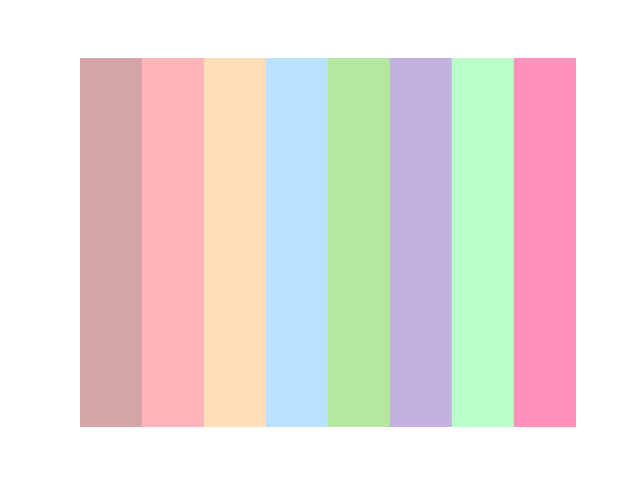

In [20]:
import matplotlib.pyplot as plt

# Show the color palette
fig, ax = plt.subplots()
rect_size = 1 / len(COLOR_PALETTE)

for i, color in enumerate(COLOR_PALETTE):
    ax.add_patch(plt.Rectangle((i * rect_size, 0), rect_size, 1, color=color))
plt.axis("off")
plt.show()

### Set Font Sizes

In [21]:
# Set default font size for various elements
def set_medium_font_size():
    plt.rcParams.update(
        {
            "font.size": 14,
            "axes.titlesize": 16,
            "axes.labelsize": 14,
            "xtick.labelsize": 12,
            "ytick.labelsize": 12,
            "legend.fontsize": 12,
            "figure.titlesize": 18,
        }
    )

def set_large_font_size():
    plt.rcParams.update(
        {
            "font.size": 18,
            "axes.titlesize": 20,
            "axes.labelsize": 18,
            "xtick.labelsize": 15,
            "ytick.labelsize": 15,
            "legend.fontsize": 15,
            "figure.titlesize": 22,
        }
    )

set_medium_font_size()

### Placement and Pairing strategies

In [22]:
import os
import sys
import torch
import numpy as np
import pandas as pd
from tqdm import trange


# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.Pairing import PairingStrategyEnum, RepeatedKDTreeStrategy, HungarianAlgorithmStrategy, GreedyStrategy
from src.TimeStep.ForAdjusting.PlacementStrategy import PlacementStrategyEnum, SinusoidStrategy, EquidistantStrategy

placement_strategy_type = PlacementStrategyEnum.EQUIDISTANT
pairing_strategy_type = PairingStrategyEnum.HUNGARIAN

if placement_strategy_type == PlacementStrategyEnum.SINUSOIDAL:
    placement_strategy = SinusoidStrategy()
else: # if placement_strategy_type == PlacementStrategyEnum.EQUIDISTANT
    placement_strategy = EquidistantStrategy()

if pairing_strategy_type == PairingStrategyEnum.KD_TREE:
    pairing_strategy = RepeatedKDTreeStrategy()
elif pairing_strategy_type == PairingStrategyEnum.GREEDY:
    pairing_strategy = GreedyStrategy()
else: # if pairing_strategy_type == PairingStrategyEnum.HUNGARIAN
    pairing_strategy = HungarianAlgorithmStrategy()

point_cloud_dir = os.path.join("plot_hits_out", placement_strategy_type.value, pairing_strategy_type.value)

device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu" # else "mps" if torch.backends.mps.is_available() else "cpu"
)

root_dir = os.path.dirname(os.path.abspath(os.getcwd()))

### Load Data

In [23]:
from src.Util.Paths import DATA_DIR
from src.Util import CoordinateSystemEnum
from src.Data.CollisionEventLoader import CollisionEventLoader
from src.TimeStep.ForAdjusting.VolumeLayer import VLTimeStep

normalize_hits = False 
time_step = VLTimeStep(placement_strategy=placement_strategy, normalize_hits=normalize_hits)

cartesian = CoordinateSystemEnum.CARTESIAN
data_loader = CollisionEventLoader(
    os.path.join(root_dir, DATA_DIR, "train_sample"),
    time_step,
    batch_size=1,
    coordinate_system=cartesian,
    normalize_hits=normalize_hits,
    device=device,
)

num_t = time_step.get_num_time_steps()

### Helper Function

In [24]:
def get_empty_df():
    return pd.DataFrame({
        "x": pd.Series(dtype="float64"),
        "y": pd.Series(dtype="float64"),
        "z": pd.Series(dtype="float64"),
        "t": pd.Series(dtype="float64"),
        "ind": pd.Series(dtype="int64"),
    })

### Determine if Computing is Needed

In [25]:
train_init_hits_path = os.path.join(point_cloud_dir, "train_init_hits.csv")
gt_hits_path = os.path.join(point_cloud_dir, "gt_hits.csv")
pred_hits_path = os.path.join(point_cloud_dir, "pred_hits.csv")
inf_init_hits_path = os.path.join(point_cloud_dir, "inf_init_hits.csv")
pred_pairs_path = os.path.join(point_cloud_dir, "pred_pairs.csv")

force_recompute = False

compute_needed = force_recompute or not all(
    os.path.exists(path) for path in [train_init_hits_path, gt_hits_path, pred_hits_path, inf_init_hits_path, pred_pairs_path]
)

## Save Hits

### Load Model

In [26]:
from src.Modules import HitSetGenerativeModel
from src.Trainer.TrainingRunIO import TrainingRunIO
from src.Util.Paths import RUNS_DIR

run_key = "38hyf9sx"
model_path = os.path.join(root_dir, RUNS_DIR, run_key, "min_loss.pth")
model: HitSetGenerativeModel = torch.load(model_path, map_location=device)[TrainingRunIO.MODEL_FIELD]
model = model.to(device)
model.eval()
print(f"Model loaded on {model.device}")


/var/folders/w0/2rh4b4h16zdgh0jjh4zcw_vr0000gn/T/ipykernel_69701/2701238793.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: HitSetGenerativeModel = torch.load(mod

Model loaded on cpu


### Compute Hits

In [27]:
from src.Util.CoordinateSystemFuncs import convert_to_cartesian, convert_to_cylindrical

if compute_needed:
    gt_hits_list, gt_batch_ind_list, _ = next(data_loader.iter_events(data_loader.val_events))

    train_init_hits_df = get_empty_df()
    gt_hits_df = get_empty_df()
    pred_hits_df = get_empty_df()
    inf_init_hits_df = get_empty_df()
    pred_pairs_df = pd.DataFrame({
        "pred_index": pd.Series(dtype="int64"),
        "gt_index": pd.Series(dtype="int64"),
        "t": pd.Series(dtype="int64"),
    })

    with torch.no_grad():
        gt_offset = 0
        pred_offset = 0

        for t in trange(num_t):
            gt_hits = gt_hits_list[t]
            gt_index = gt_batch_ind_list[t]
            gt_size, gt_part_ids, gt_hits = data_loader.get_gt_size(gt_hits, gt_index, t, use_shell_parts=True)
            batch_size = data_loader.batch_size

            # Training Init Hits and GT Hits
            init_hits = time_step.place_hits(t, gt_size, coordinate_system=cartesian, device=device)

            pairs = pairing_strategy.create_pairs(init_hits, gt_hits, gt_index, gt_index, gt_part_ids, gt_part_ids)[0]

            dists = torch.linalg.vector_norm(init_hits[pairs[:, 0]] - gt_hits[pairs[:, 1]], dim=1)
            print(f"GT to (Train) Init at {t}: max dist: {dists.max()}, mean dist: {dists.mean()}")
            
            train_init_hits_df_new = pd.DataFrame(init_hits[pairs[:, 0]].cpu().numpy(), columns=["x", "y", "z"])
            train_init_hits_df_new["t"] = t
            train_init_hits_df_new["ind"] = np.arange(init_hits.size(0)) + gt_offset
            train_init_hits_df = pd.concat([train_init_hits_df, train_init_hits_df_new], ignore_index=True)

            gt_hits = gt_hits[pairs[:, 1]]
            gt_hits_df_new = pd.DataFrame(gt_hits.cpu().numpy(), columns=["x", "y", "z"])
            gt_hits_df_new["t"] = t
            gt_hits_df_new["ind"] = np.arange(gt_hits.size(0)) + gt_offset
            gt_hits_df = pd.concat([gt_hits_df, gt_hits_df_new], ignore_index=True)

            # Inference Init Hits and Pred Hits
            gt_hits_ = model.time_step.normalize_hit_tensor(gt_hits, t, cartesian)
            if model.coordinate_system == CoordinateSystemEnum.CYLINDRICAL:
                gt_hits_ = convert_to_cylindrical(gt_hits_, cartesian, theta_normalized=True)

            if t > 0:
                _, pred_hits_, used_size = model.generate(in_hits, in_index, t, batch_size=batch_size)
                init_hits = model.time_step.place_hits(t, used_size, coordinate_system=cartesian, device=device)
                init_hits = model.time_step.unnormalize_hit_tensor(init_hits, t, cartesian)

                pred_index = torch.tensor([], device=device, dtype=torch.long)
                pred_part_ids = torch.tensor([], device=device, dtype=torch.long)
                for b in range(batch_size):
                    batch_len = (used_size[b].sum().item(), )
                    pred_index = torch.cat([pred_index, torch.full(batch_len, b, device=device, dtype=torch.long)])
                    new_part_ids = torch.repeat_interleave(torch.arange(used_size[b].size(0), device=device), used_size[b])
                    pred_part_ids = torch.cat([pred_part_ids, new_part_ids])

                print(f"Number of entries in pred_hits: {pred_hits_.size(0)}, and in gt_hits: {gt_hits_.size(0)}")

                pred_hits = convert_to_cartesian(pred_hits_, model.coordinate_system)
                pred_hits = model.time_step.unnormalize_hit_tensor(pred_hits, t, cartesian)
                pairs = pairing_strategy.create_pairs(pred_hits, gt_hits, pred_index, gt_index, pred_part_ids, gt_part_ids)[0]

                dists = torch.linalg.vector_norm(pred_hits[pairs[:, 0]] - gt_hits[pairs[:, 1]], dim=1)
                print(f"Pred to GT at {t}: max dist: {dists.max()}, mean dist: {dists.mean()}")

                dists = torch.linalg.vector_norm(init_hits - pred_hits, dim=1)
                print(f"Init to Pred at {t}: max dist: {dists.max()}, mean dist: {dists.mean()}")

                dists = torch.linalg.vector_norm(init_hits[pairs[:, 0]] - gt_hits[pairs[:, 1]], dim=1)
                print(f"Init to GT at {t}: max dist: {dists.max()}, mean dist: {dists.mean()}")

                pred_hits_df_new = pd.DataFrame(pred_hits.cpu().numpy(), columns=["x", "y", "z"])
                pred_hits_df_new["t"] = t
                pred_hits_df_new["ind"] = np.arange(pred_hits.size(0)) + pred_offset
                pred_hits_df = pd.concat([pred_hits_df, pred_hits_df_new], ignore_index=True)

                inf_init_hits_df_new = pd.DataFrame(init_hits.cpu().numpy(), columns=["x", "y", "z"])
                inf_init_hits_df_new["t"] = t
                inf_init_hits_df_new["ind"] = np.arange(init_hits.size(0)) + pred_offset
                inf_init_hits_df = pd.concat([inf_init_hits_df, inf_init_hits_df_new], ignore_index=True)

                pairs[:, 0] = pairs[:, 0] + pred_offset
                pairs[:, 1] = pairs[:, 1] + gt_offset
                pred_offset += pred_hits.size(0)

                pred_pairs_df_new = pd.DataFrame(pairs.cpu().numpy(), columns=["pred_index", "gt_index"])
                pred_pairs_df_new["t"] = t
                pred_pairs_df = pd.concat([pred_pairs_df, pred_pairs_df_new], ignore_index=True)

            in_hits = gt_hits_
            in_index = gt_index
            gt_offset += gt_hits.size(0)

    os.makedirs(point_cloud_dir, exist_ok=True)
    train_init_hits_df.to_csv(train_init_hits_path, index=False)
    gt_hits_df.to_csv(gt_hits_path, index=False)
    pred_hits_df.to_csv(pred_hits_path, index=False)
    inf_init_hits_df.to_csv(inf_init_hits_path, index=False)
    pred_pairs_df.to_csv(pred_pairs_path, index=False)

else: # The points have already been generated
    train_init_hits_df = pd.read_csv(train_init_hits_path)
    gt_hits_df = pd.read_csv(gt_hits_path)
    pred_hits_df = pd.read_csv(pred_hits_path)
    inf_init_hits_df = pd.read_csv(inf_init_hits_path)
    pred_pairs_df = pd.read_csv(pred_pairs_path)

## Analyze Calculation Output

In [28]:
import re

# Initialize lists to store the extracted data
num_gt_points = []
num_pred_points = []
mean_dist_train_init_to_gt = []
max_dist_train_init_to_gt = []
mean_dist_init_to_pred = []
max_dist_init_to_pred = []
mean_dist_init_to_gt = []
max_dist_init_to_gt = []
mean_dist_pred_to_gt = []
max_dist_pred_to_gt = []

# Regular expressions to match the relevant lines in the log file
num_points_pattern = re.compile(r"Number of entries in pred_hits: (\d+), and in gt_hits: (\d+)")
dist_train_init_to_gt_pattern = re.compile(r"GT to \(Train\) Init at \d+: max dist: ([\d.]+), mean dist: ([\d.]+)")
dist_init_to_pred_pattern = re.compile(r"Init to Pred at \d+: max dist: ([\d.]+), mean dist: ([\d.]+)")
dist_init_to_gt_pattern = re.compile(r"Init to GT at \d+: max dist: ([\d.]+), mean dist: ([\d.]+)")
dist_pred_to_gt_pattern = re.compile(r"Pred to GT at \d+: max dist: ([\d.]+), mean dist: ([\d.]+)")

# Read the log file and extract the data
with open(os.path.join(point_cloud_dir, "out.log"), "r") as file:
    for line in file:
        num_points_match = num_points_pattern.search(line)
        if num_points_match:
            num_pred_points.append(int(num_points_match.group(1)))
            num_gt_points.append(int(num_points_match.group(2)))

        dist_train_init_to_gt_match = dist_train_init_to_gt_pattern.search(line)
        if dist_train_init_to_gt_match:
            max_dist_train_init_to_gt.append(float(dist_train_init_to_gt_match.group(1)))
            mean_dist_train_init_to_gt.append(float(dist_train_init_to_gt_match.group(2)))

        dist_init_to_pred_match = dist_init_to_pred_pattern.search(line)
        if dist_init_to_pred_match:
            max_dist_init_to_pred.append(float(dist_init_to_pred_match.group(1)))
            mean_dist_init_to_pred.append(float(dist_init_to_pred_match.group(2)))

        dist_init_to_gt_match = dist_init_to_gt_pattern.search(line)
        if dist_init_to_gt_match:
            max_dist_init_to_gt.append(float(dist_init_to_gt_match.group(1)))
            mean_dist_init_to_gt.append(float(dist_init_to_gt_match.group(2)))

        dist_pred_to_gt_match = dist_pred_to_gt_pattern.search(line)
        if dist_pred_to_gt_match:
            max_dist_pred_to_gt.append(float(dist_pred_to_gt_match.group(1)))
            mean_dist_pred_to_gt.append(float(dist_pred_to_gt_match.group(2)))

# Print the extracted lists
print("Number of GT points:", num_gt_points)
print("Number of predicted points:", num_pred_points)
print("Mean distances between train init and GT:", mean_dist_train_init_to_gt)
print("Max distances between train init and GT:", max_dist_train_init_to_gt)
print("Mean distances between init and pred:", mean_dist_init_to_pred)
print("Max distances between init and pred:", max_dist_init_to_pred)
print("Mean distances between init and GT:", mean_dist_init_to_gt)
print("Max distances between init and GT:", max_dist_init_to_gt)
print("Mean distances between pred and GT:", mean_dist_pred_to_gt)
print("Max distances between pred and GT:", max_dist_pred_to_gt)

Number of GT points: [18712, 16907, 21590, 9324, 11518, 10374, 15668]
Number of predicted points: [16594, 15145, 19622, 8259, 10379, 9231, 14202]
Mean distances between train init and GT: [115.19561004638672, 51.91251754760742, 45.92535400390625, 92.51880645751953, 67.75914764404297, 76.17437744140625, 74.187255859375, 75.14682006835938]
Max distances between train init and GT: [464.07513427734375, 467.3481140136719, 449.19525146484375, 1044.5904541015625, 1217.4112548828125, 1063.4058837890625, 437.6413269042969, 1547.812255859375]
Mean distances between init and pred: [45.25919723510742, 40.16592025756836, 73.99378204345703, 60.94557571411133, 60.258052825927734, 65.28497314453125, 620.7354125976562]
Max distances between init and pred: [168.41754150390625, 115.97042083740234, 355.474365234375, 257.1156005859375, 174.79733276367188, 217.9927520751953, 2852.220947265625]
Mean distances between init and GT: [47.69746017456055, 41.96885299682617, 84.1722183227539, 60.34397506713867, 63.

In [29]:
from matplotlib import pyplot as plt

show_plots = True
save_plots = True

def show_and_save_plot(fig, path, show=show_plots, save=save_plots):
    if save:
        fig.tight_layout()
        fig.savefig(path)
    if show:
        plt.show()
    else:
        plt.close()


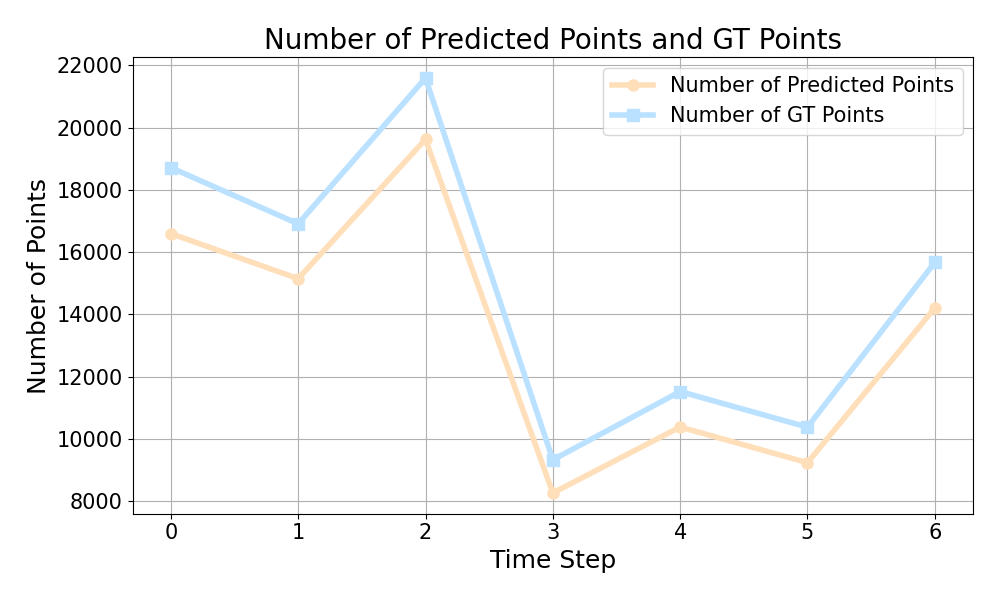

In [30]:
# Plot 1: Number of predicted points and number of gt points
set_large_font_size()

plt.figure(figsize=(10, 6))
plt.plot(num_pred_points, label='Number of Predicted Points',
         marker='o', color=COLOR_PALETTE[2], linewidth=4, markersize=8)
plt.plot(num_gt_points, label='Number of GT Points',
         marker='s', color=COLOR_PALETTE[3], linewidth=4, markersize=8)
plt.xlabel('Time Step')
plt.ylabel('Number of Points')
plt.title('Number of Predicted Points and GT Points')
plt.legend()
plt.grid(True)

show_and_save_plot(plt, os.path.join(point_cloud_dir, "num_points.png"))

set_medium_font_size()

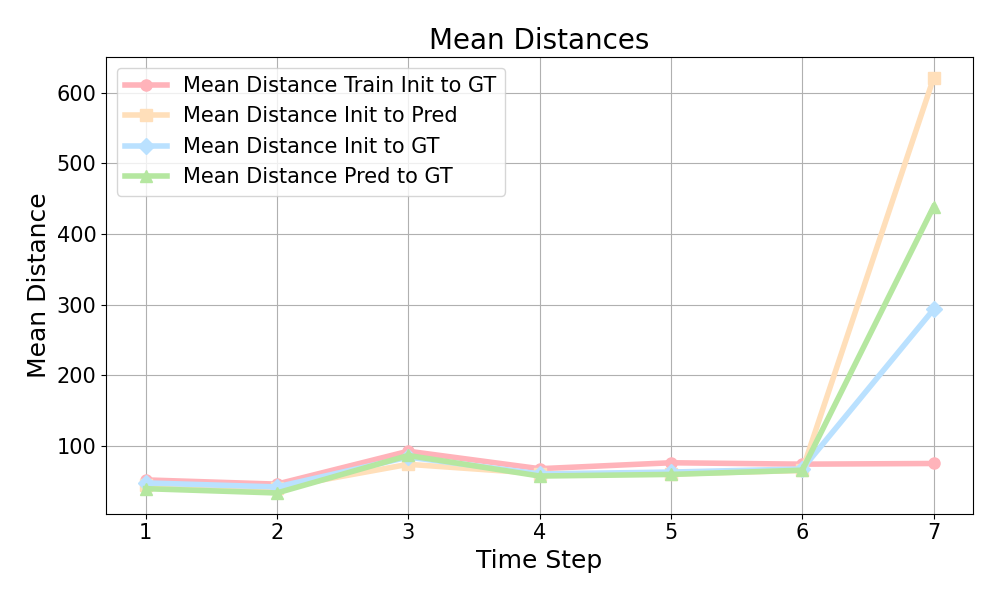

In [31]:
# Plot 2: Mean distances
set_large_font_size()

plt.figure(figsize=(10, 6))
x_values = np.arange(1, num_t)
plt.plot(x_values, mean_dist_train_init_to_gt[1:], label='Mean Distance Train Init to GT',
         marker='o', color=COLOR_PALETTE[1], linewidth=4, markersize=8)
plt.plot(x_values, mean_dist_init_to_pred, label='Mean Distance Init to Pred',
         marker='s', color=COLOR_PALETTE[2], linewidth=4, markersize=8)
plt.plot(x_values, mean_dist_init_to_gt, label='Mean Distance Init to GT',
         marker='D', color=COLOR_PALETTE[3], linewidth=4, markersize=8)
plt.plot(x_values, mean_dist_pred_to_gt, label='Mean Distance Pred to GT',
         marker='^', color=COLOR_PALETTE[4], linewidth=4, markersize=8)
plt.xlabel('Time Step')
plt.ylabel('Mean Distance')
plt.title('Mean Distances')
plt.legend()
plt.grid(True)

show_and_save_plot(plt, os.path.join(point_cloud_dir, "mean_distances.png"))

set_medium_font_size()

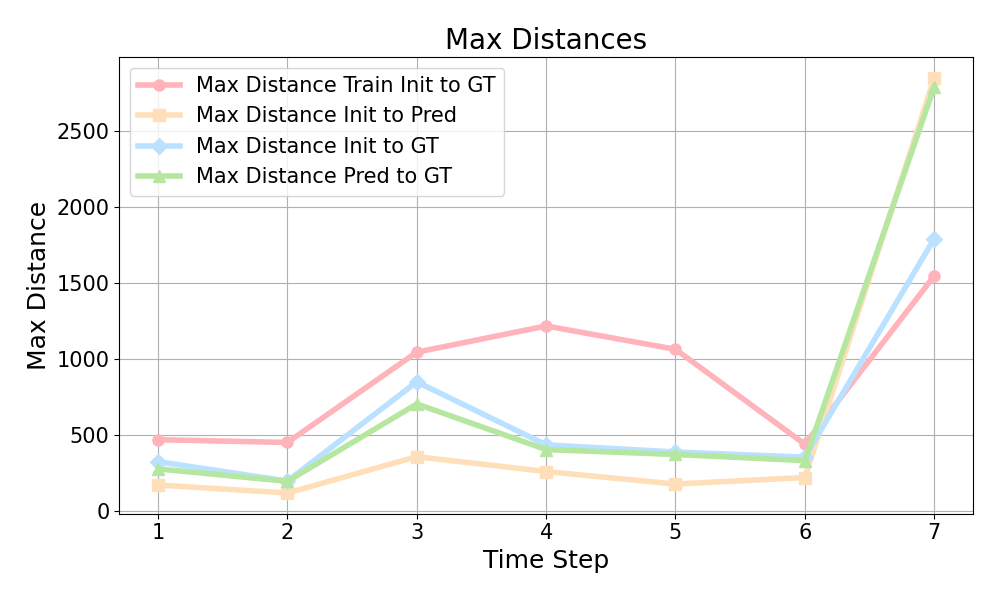

In [32]:
# Plot 3: Max distances
set_large_font_size()

plt.figure(figsize=(10, 6))
plt.plot(x_values, max_dist_train_init_to_gt[1:], label='Max Distance Train Init to GT',
         marker='o', color=COLOR_PALETTE[1], linewidth=4, markersize=8)
plt.plot(x_values, max_dist_init_to_pred, label='Max Distance Init to Pred',
         marker='s', color=COLOR_PALETTE[2], linewidth=4, markersize=8)
plt.plot(x_values, max_dist_init_to_gt, label='Max Distance Init to GT',
         marker='D', color=COLOR_PALETTE[3], linewidth=4, markersize=8)
plt.plot(x_values, max_dist_pred_to_gt, label='Max Distance Pred to GT',
         marker='^', color=COLOR_PALETTE[4], linewidth=4, markersize=8)
plt.xlabel('Time Step')
plt.ylabel('Max Distance')
plt.title('Max Distances')
plt.legend()
plt.grid(True)
plt.xticks(x_values)  # Ensure x-axis ticks match the x_values

show_and_save_plot(plt, os.path.join(point_cloud_dir, "max_distances.png"))

set_medium_font_size()

## Visualize

### Arrow Class

In [33]:
from collections import namedtuple
from mpl_toolkits.mplot3d import Axes3D, art3d, proj3d
from matplotlib.patches import FancyArrowPatch

# Based on: https://stackoverflow.com/a/22867877 and https://github.com/matplotlib/matplotlib/issues/21688#issuecomment-974912574

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        return np.min(zs)

def add_arrow(ax, start, end, color, width, style):
    arrow = Arrow3D([start.z, end.z], [start.x, end.x], [start.y, end.y], color=color, alpha=0.75,
                    linewidth=width, mutation_scale=8, arrowstyle='-|>', shrinkA=0, shrinkB=0, linestyle=style)
    ax.add_artist(arrow)

### Visualization Function

In [34]:
%matplotlib widget

from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm, ListedColormap
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def create_3d_hit_plot(
        train_init_hits: pd.DataFrame = None,
        gt_hits: pd.DataFrame = None,
        inf_init_hits: pd.DataFrame = None,
        pred_hits: pd.DataFrame = None,
        pred_gt_pairs: pd.DataFrame = None,
        point_size: int = 5,
        line_size: int = 0.75,
    ):
    """
    Create an interactive 3D scatter plot of hits colored by a specified column. 

    :param train_init_hits pd.Dataframe: The initially placed hits during training
    :param gt_hits pd.Dataframe: The ground truth hits
    :param inf_init_hits pd.Dataframe: The initially placed hits during inference
    :param pred_hits pd.Dataframe: The predicted hits
    :param pred_gt_pairs pd.Dataframe: The predicted to ground truth hit pairs
    :param point_size int: The size of the points in the
    :param line_size int: The size of the lines connecting the points
    """
    # Select non-None dataframe
    reference_df = (
        train_init_hits if train_init_hits is not None else
        gt_hits if gt_hits is not None else
        inf_init_hits if inf_init_hits is not None else
        pred_hits
    )
    if reference_df is None:
        return

    # Define a colormap
    unique_t_values = np.sort(reference_df["t"].unique())
    N_t = len(unique_t_values)
    t_to_color = {t: COLOR_PALETTE[i % len(COLOR_PALETTE)] for i, t in enumerate(unique_t_values)}

    # Create a ListedColormap and BoundaryNorm for the color bar
    colors = [t_to_color[t] for t in unique_t_values]
    listed_cmap = ListedColormap(colors)
    norm = BoundaryNorm(boundaries=np.arange(N_t + 1) - 0.5, ncolors=N_t)

    # Calculate consistent limits for x, y, and z
    x_min, x_max = reference_df["x"].min(), reference_df["x"].max()
    y_min, y_max = reference_df["y"].min(), reference_df["y"].max()
    z_min, z_max = reference_df["z"].min(), reference_df["z"].max()

    # Define markers and line styles
    markers = ["o", "x", "s", "*"]
    line_styles = ["dotted", "dashdot", "solid"]

    # Function to create the plot
    def create_plot(
            f_train_init: pd.DataFrame = None,
            f_gt: pd.DataFrame = None,
            f_inf_init: pd.DataFrame = None,
            f_pred: pd.DataFrame = None,
            f_pred_gt_pairs: pd.DataFrame = None,
            show_train_connections: bool = True,
            show_inf_connections: bool = True,
    ):
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection="3d")
        
        for f, style in zip(
            [f_train_init, f_gt, f_inf_init, f_pred], markers
        ):
            if f is not None:
                colors = f["t"].map(t_to_color)
                _sc = ax.scatter(
                    f["z"], f["x"], f["y"], c=colors, alpha=0.75, s=point_size, marker=style
                )

        for start, end, show, style in zip(
            [f_train_init, f_inf_init], [f_gt, f_pred],
            [show_train_connections, show_inf_connections], line_styles[:2]
        ):
            if show and start is not None and end is not None:
                for s, e in zip(start.itertuples(index=False), end.itertuples(index=False)):
                    add_arrow(ax, s, e, t_to_color[s.t], line_size, style)

        if f_pred_gt_pairs is not None and f_pred is not None and f_gt is not None:
            for pair in f_pred_gt_pairs.itertuples(index=False):
                s = f_pred.loc[f_pred["ind"] == pair.pred_index].iloc[0]
                e = f_gt.loc[f_gt["ind"] == pair.gt_index].iloc[0]
                add_arrow(ax, s, e, t_to_color[s.t], line_size, line_styles[2])

        # Add color bar
        sm = ScalarMappable(cmap=listed_cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, shrink=0.5, aspect=4, anchor=(1, 0.25))
        cbar.set_label("Shell (t)")
        cbar.set_ticks(np.arange(N_t))
        cbar.set_ticklabels([int(t) for t in unique_t_values])

        # Add marker and line style legend next to color bar
        labels = ["Train Init", "GT", "Inf Init", "Pred", "Train to GT", "Inf to Pred", "Pred to GT"]
        legend_ax = fig.add_axes([0.85, -0.15, 0.1, 1.0])
        legend_ax.axis('off')  # Turn off the axis

        # Add custom markers and line styles to the legend Axes
        for i, (style, label) in enumerate(zip(markers + line_styles, labels)):
            if i < 4:  # Markers
                legend_ax.plot([], [], marker=style, color="black", label=label, linestyle="None", markersize=10)
            else:  # Line styles
                legend_ax.plot([], [], linestyle=style, color="black", label=label)
        legend_ax.legend(loc="upper right")

        # Set labels
        ax.set_xlabel("Z")
        ax.set_ylabel("X")
        ax.set_zlabel("Y")
        ax.set_title("3D Scatter Plot of Hits")

        # Set consistent limits
        ax.set_xlim(z_min, z_max)
        ax.set_ylim(x_min, x_max)
        ax.set_zlim(y_min, y_max)

        plt.show()


    # Function to update the plot based on the selected t range
    def update_plot(
            t_range, show_train_init, show_gt, show_inf_init, show_pred,
            show_train_to_gt, show_inf_to_pred, show_pred_to_gt
    ):
        min_t, max_t = t_range[0] - 0.0001, t_range[1] + 0.0001
        f_train_init = (
            train_init_hits[(train_init_hits["t"] >= min_t) & (train_init_hits["t"] <= max_t)]
            if show_train_init and train_init_hits is not None else None
        )
        f_gt = (
            gt_hits[(gt_hits["t"] >= min_t) & (gt_hits["t"] <= max_t)]
            if show_gt and gt_hits is not None else None
        )
        f_inf_init = (
            inf_init_hits[(inf_init_hits["t"] >= min_t) & (inf_init_hits["t"] <= max_t)]
            if show_inf_init and inf_init_hits is not None else None
        )
        f_pred = (
            pred_hits[(pred_hits["t"] >= min_t) & (pred_hits["t"] <= max_t)]
            if show_pred and pred_hits is not None else None
        )
        f_pairs = (
            pred_gt_pairs[(pred_gt_pairs["t"] >= min_t) & (pred_gt_pairs["t"] <= max_t)]
            if pred_gt_pairs is not None else None
        )

        if all([f is None for f in [f_train_init, f_gt, f_inf_init, f_pred]]):        
            print("No hits selected")
        else:
            f_pairs = f_pairs if show_pred_to_gt else None
            create_plot(
                f_train_init, f_gt, f_inf_init, f_pred, f_pairs,
                show_train_to_gt, show_inf_to_pred
            )


    # Create a range slider widget for t selection
    t_slider = widgets.FloatRangeSlider(
        value=[train_init_hits["t"].min(), train_init_hits["t"].max()],
        min=train_init_hits["t"].min(),
        max=train_init_hits["t"].max(),
        step=1,
        description="t range:",
    )
    # Add checkboxes for selecting which hits to show
    show_train_init = widgets.Checkbox(value=True, description="Train Init")
    show_gt = widgets.Checkbox(value=True, description="GT")
    show_inf_init = widgets.Checkbox(value=True, description="Inf Init")
    show_pred = widgets.Checkbox(value=True, description="Pred")
    show_train_to_gt = widgets.Checkbox(value=False, description="Train to GT")
    show_inf_to_pred = widgets.Checkbox(value=False, description="Inf to Pred")
    show_pred_to_gt = widgets.Checkbox(value=False, description="Pred to GT")

    # Arrange UI
    hit_checkboxes = widgets.HBox(
        [show_train_init, show_gt, show_inf_init, show_pred],
        layout=widgets.Layout(margin="0px", padding="0px")
    )
    edge_checkboxes = widgets.HBox(
        [show_train_to_gt, show_inf_to_pred, show_pred_to_gt],
        layout=widgets.Layout(margin="0px", padding="0px")
    )

    output = widgets.interactive_output(update_plot, {
        "t_range": t_slider, "show_train_init": show_train_init, "show_gt": show_gt,
        "show_inf_init": show_inf_init, "show_pred": show_pred, "show_train_to_gt": show_train_to_gt,
        "show_inf_to_pred": show_inf_to_pred, "show_pred_to_gt": show_pred_to_gt
    })
    display(t_slider, hit_checkboxes, edge_checkboxes, output)


### Subsample Data

In [35]:
s_indices = train_init_hits_df.sample(frac=0.005).index
s_train_init_df = train_init_hits_df[train_init_hits_df["ind"].isin(s_indices)]
s_gt_df = gt_hits_df[gt_hits_df["ind"].isin(s_train_init_df["ind"])]

s_pairings = pred_pairs_df[pred_pairs_df["gt_index"].isin(s_gt_df["ind"])]
s_inf_init_df = inf_init_hits_df[inf_init_hits_df["ind"].isin(s_pairings["pred_index"])]
s_pred_df = pred_hits_df[pred_hits_df["ind"].isin(s_pairings["pred_index"])]

print("Selected:")
print(f"From GT and Train Init: {s_train_init_df.shape[0]}")
print(f"From Pred and Inf Init: {s_inf_init_df.shape[0]}")
print(f"Pairs: {s_pairings.shape[0]}")

Selected:
From GT and Train Init: 603
From Pred and Inf Init: 477
Pairs: 477


### Do Visualization

In [36]:
create_3d_hit_plot(s_train_init_df, s_gt_df, s_inf_init_df, s_pred_df, s_pairings, point_size=15, line_size=2)

FloatRangeSlider(value=(0.0, 7.0), description='t range:', max=7.0, step=1.0)

Output()